# Chapter 11 - Notes

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 11.1 Binomial regresssion

### 11.1.1 Logistic regression: Prosocial chimpanzees

In [5]:
# load the data
chimps = load_data(CHIMPANZEES_FILE, delimiter=";")

Start with the simplified model. We plot the prior on $p$ for different priors on $\alpha$

In [6]:
def sample_constant_model_prior(chimps, alpha_prior_sigma):
    with pm.Model():
        # prior
        alpha = pm.Normal("alpha", mu=0, sigma=alpha_prior_sigma)

        # model
        p = pm.Deterministic("p", pm.math.invlogit(alpha))

        # likelihood
        pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=chimps.pulled_left)

        # sample prior predictive
        pp_trace = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

    return pp_trace

Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]


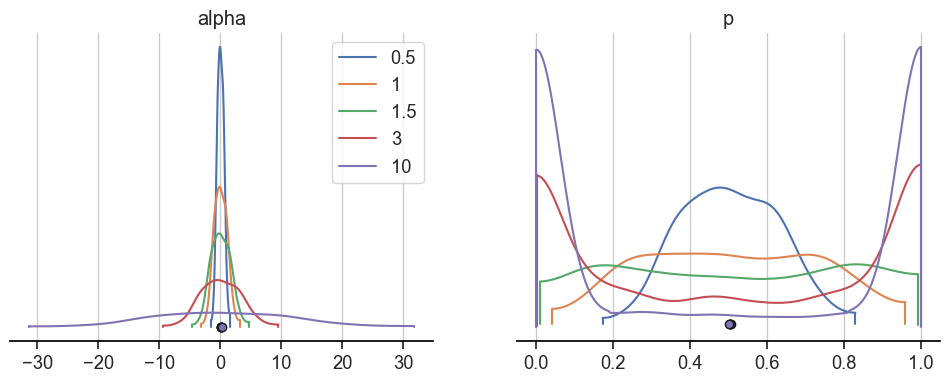

In [7]:
sigmas = [0.5, 1, 1.5, 3, 10]
traces = []
for sigma in sigmas:
    traces.append(sample_constant_model_prior(chimps, sigma))

pm.plot_density(
    traces,
    group="prior",
    data_labels=sigmas,
    var_names=["alpha", "p"],
    hdi_prob=1,
    figsize=(12, 4),
);

Now we create an index variable for treatment.
We also need to create an index for `actor` so that it goes from 0.

In [8]:
chimps["treatment_idx"] = chimps["prosoc_left"] + 2 * chimps["condition"]

treatment_mapper = {
    0: "R/N",
    1: "L/N",
    2: "R/P",
    3: "L/P",
}
chimps["treatment"] = chimps["treatment_idx"].replace(treatment_mapper)

chimps["actor_idx"] = chimps["actor"] - 1

Now do the same but with a fixed $\alpha$ and different priors on $\beta$.

In [9]:
def sample_no_agent_effect_model_prior(chimps, beta_prior_sigma):
    treatments = chimps.sort_values("treatment_idx").treatment.unique()
    coords = {
        "treatment": treatments,
    }
    with pm.Model(coords=coords):
        # data
        treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

        # priors
        alpha = pm.Normal("alpha", mu=0, sigma=1.5)
        beta = pm.Normal("beta", mu=0, sigma=beta_prior_sigma, dims="treatment")

        # left/right treatment effect
        diff_between_treatments = pm.Deterministic(
            "diff_between_treatments",
            pm.math.abs(
                pm.math.invlogit(alpha + beta[1]) - pm.math.invlogit(alpha + beta[0])
            ),
        )

        # linear model
        p = pm.Deterministic(
            "p", pm.math.invlogit(alpha + beta[treatment_idx]), dims="obs"
        )

        # likelihood
        pulled_left = pm.Binomial(
            "pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs"
        )

        # sample the prior predictive
        trace = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

    return trace

Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]


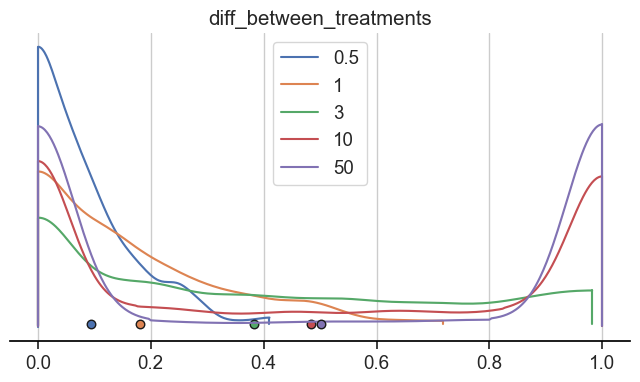

In [10]:
sigmas = [0.5, 1, 3, 10, 50]
traces = []
for sigma in sigmas:
    traces.append(sample_no_agent_effect_model_prior(chimps, sigma))

pm.plot_density(
    traces,
    group="prior",
    data_labels=sigmas,
    var_names=["diff_between_treatments"],
    hdi_prob=1,
    figsize=(8, 4),
);

Finally let's do a sensible model

In [11]:
actors = chimps.sort_values("actor_idx").actor.unique()
treatments = chimps.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m11_3:
    # data
    actor_idx = pm.MutableData("actor", chimps.actor_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="actor")
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="treatment")

    # linear model
    p = pm.Deterministic(
        "p", pm.math.invlogit(alpha[actor_idx] + beta[treatment_idx]), dims="obs"
    )

    # likelihood
    pulled_left = pm.Binomial(
        "pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs"
    )

    # sample the prior predictive
    trace_11_3 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Summarise posteriors

In [12]:
az.summary(
    trace_11_3, var_names=["alpha", "beta"], kind="stats", hdi_prob=0.97, round_to=2
)

,mean,sd,hdi_1.5%,hdi_98.5%
alpha[1],-0.44,0.33,-1.21,0.22
alpha[2],3.91,0.76,2.34,5.62
alpha[3],-0.74,0.33,-1.47,-0.04
alpha[4],-0.74,0.33,-1.47,-0.04
alpha[5],-0.45,0.33,-1.24,0.21
alpha[6],0.48,0.34,-0.22,1.26
alpha[7],1.96,0.42,1.07,2.86
beta[R/N],-0.05,0.29,-0.66,0.58
beta[L/N],0.47,0.28,-0.13,1.09
beta[R/P],-0.39,0.28,-0.99,0.22


Now we compare the posteriors for the $\alpha$ values and their inverse logits (i.e. actual probability values)

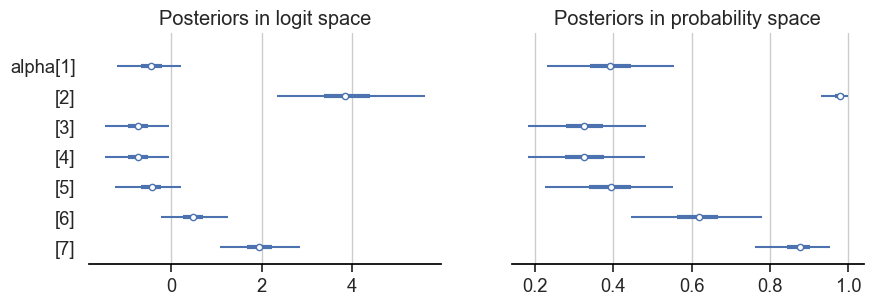

In [13]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))

az.plot_forest(
    trace_11_3,
    var_names=["alpha"],
    hdi_prob=0.97,
    combined=True,
    ax=axs[0],
)
axs[0].set_title("Posteriors in logit space")

az.plot_forest(
    expit(trace_11_3.posterior.alpha),
    hdi_prob=0.97,
    combined=True,
    ax=axs[1],
)
axs[1].set_title("Posteriors in probability space");

Now the treatment effect, controlling for individual agent.

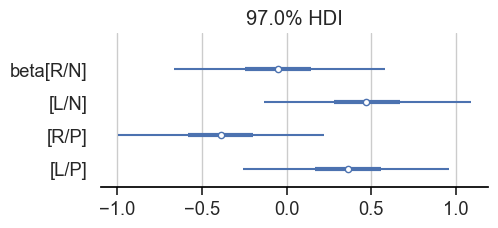

In [14]:
az.plot_forest(
    trace_11_3,
    var_names=["beta"],
    hdi_prob=0.97,
    combined=True,
    figsize=(5, 2),
);

Let's plot the contrasts

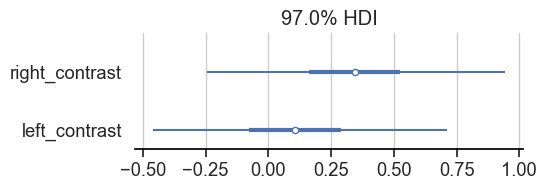

In [15]:
trace_11_3.posterior["right_contrast"] = trace_11_3.posterior.beta.sel(
    treatment="R/N"
) - trace_11_3.posterior.beta.sel(treatment="R/P")
trace_11_3.posterior["left_contrast"] = trace_11_3.posterior.beta.sel(
    treatment="L/N"
) - trace_11_3.posterior.beta.sel(treatment="L/P")

az.plot_forest(
    trace_11_3,
    var_names=["contrast"],
    filter_vars="regex",
    hdi_prob=0.97,
    combined=True,
    figsize=(5, 1.5),
);

### 11.1.3 Aggregated binomial: Chimpanzees again, condensed

In [16]:
# load the data
chimps = load_data(CHIMPANZEES_FILE, delimiter=";")

chimps["treatment_idx"] = chimps["prosoc_left"] + 2 * chimps["condition"]

treatment_mapper = {
    0: "R/N",
    1: "L/N",
    2: "R/P",
    3: "L/P",
}
chimps["treatment"] = chimps["treatment_idx"].replace(treatment_mapper)

chimps["actor_idx"] = chimps["actor"] - 1

Aggregate the data

In [17]:
chimps_agg = (
    chimps.groupby(
        ["treatment", "treatment_idx", "actor", "actor_idx", "prosoc_left", "condition"]
    )
    .pulled_left.sum()
    .reset_index()
    .rename(columns={"pulled_left": "left_pulls"})
)
chimps_agg.head(5)

,treatment,treatment_idx,actor,actor_idx,prosoc_left,condition,left_pulls
0,L/N,1,1,0,1,0,9
1,L/N,1,2,1,1,0,18
2,L/N,1,3,2,1,0,11
3,L/N,1,4,3,1,0,9
4,L/N,1,5,4,1,0,10


Now we can refit the model using all 18 trials at once.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


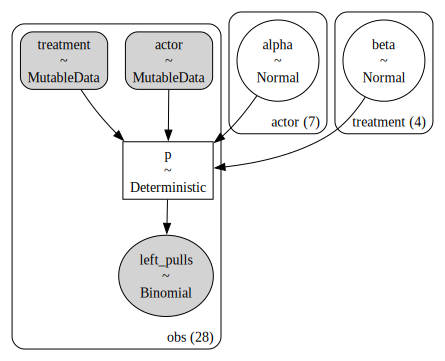

In [18]:
n_trials = 18

actors = chimps_agg.sort_values("actor_idx").actor.unique()
treatments = chimps_agg.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m11_4:
    # data
    actor_idx = pm.MutableData("actor", chimps_agg.actor_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps_agg.treatment_idx, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="actor")
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="treatment")

    # linear model
    p = pm.Deterministic(
        "p", pm.math.invlogit(alpha[actor_idx] + beta[treatment_idx]), dims="obs"
    )

    # likelihood
    left_pulls = pm.Binomial(
        "left_pulls", n=n_trials, p=p, observed=chimps_agg.left_pulls, dims="obs"
    )

    # sample the prior predictive
    trace_11_4 = pm.sample(random_seed=RANDOM_SEED)


m11_4.to_graphviz()

Let's compare the posteriors

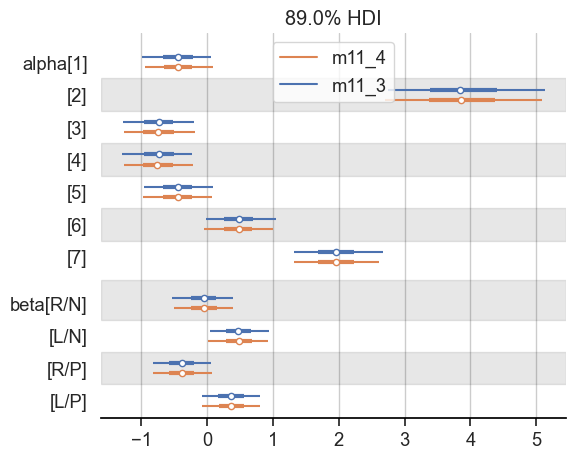

In [19]:
az.plot_forest(
    [trace_11_3, trace_11_4],
    model_names=["m11_3", "m11_4"],
    var_names=["alpha", "beta"],
    filter_vars="regex",
    combined=True,
    hdi_prob=0.89,
    figsize=(6, 5),
);

Observe that the posteriors are identical

### 11.1.4 Aggregated binomial: Graduate school admissions

In [20]:
# load the data
admit = load_data(ADMISSIONS_FILE, delimiter=";")

# cleaning
admit = admit.rename(
    columns={
        "applicant.gender": "gender",
    }
)

admit["admission_rate"] = admit["admit"] / admit["applications"]

# create index variables
admit["gender_idx"], genders = pd.factorize(admit["gender"])
admit["dept_idx"], depts = pd.factorize(admit["dept"])

Start with a simple model with only gender as a feature

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


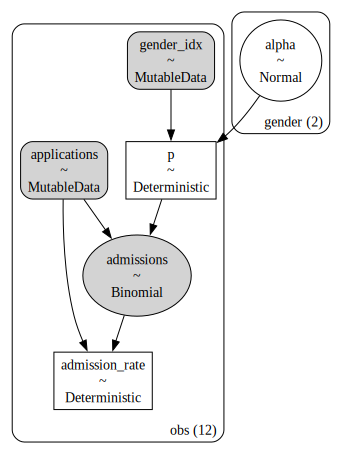

In [21]:
coords = {
    "obs": admit.index,
    "gender": genders,
}
with pm.Model(coords=coords) as m11_7:
    # data
    gender_idx = pm.MutableData("gender_idx", admit.gender_idx, dims="obs")
    applications = pm.MutableData("applications", admit.applications, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="gender")

    # model
    p = pm.Deterministic("p", pm.math.invlogit(alpha[gender_idx]), dims="obs")

    # likelihood
    admissions = pm.Binomial(
        "admissions", n=applications, p=p, observed=admit.admit, dims="obs"
    )
    admission_rate = pm.Deterministic(
        "admission_rate", admissions / applications, dims="obs"
    )

    # inference button
    trace_11_7 = pm.sample(random_seed=RANDOM_SEED)


m11_7.to_graphviz()

In [22]:
az.summary(
    trace_11_7,
    var_names=["alpha"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[male],-0.219,0.040,-0.285,-0.157
alpha[female],-0.830,0.051,-0.911,-0.748


Let's get the absolute and relative contrasts

In [23]:
with m11_7:
    male_idx = genders.get_loc("male")
    female_idx = genders.get_loc("female")

    abs_contrast = pm.Deterministic("abs_contrast", alpha[male_idx] - alpha[female_idx])
    rel_contrast = pm.Deterministic(
        "rel_contrast",
        pm.math.invlogit(alpha[male_idx]) - pm.math.invlogit(alpha[female_idx]),
    )

    # need to resample
    trace_11_7 = pm.sample(random_seed=RANDOM_SEED)


az.summary(
    trace_11_7,
    var_names=["contrast"],
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
abs_contrast,0.611,0.066,0.503,0.711
rel_contrast,0.142,0.015,0.119,0.165


Now let's do a posterior validation check

In [24]:
with m11_7:
    trace_11_7 = pm.sample_posterior_predictive(
        trace_11_7,
        var_names=["admissions", "admission_rate"],
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

Sampling: [admissions]


In [25]:
def plot_posterior_preditive_checks_by_observation(
    admit, trace, hdi_prob=0.89, ax=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(7, 3))

    sns.scatterplot(
        x=admit.index,
        y=admit.admission_rate,
        ax=ax,
    )
    for dept in depts:
        dept_data = admit[admit["dept"] == dept]
        ax.plot(
            dept_data.index,
            dept_data.admission_rate,
            color=colors[0],
        )

    sns.scatterplot(
        x=admit.index,
        y=trace.posterior.p.mean(dim=["draw", "chain"]),
        facecolors="none",
        edgecolor="k",
        linewidth=1,
    )

    p_hdi = az.hdi(trace.posterior.p, hdi_prob=0.89)
    ax.plot(
        [admit.index, admit.index],
        [p_hdi.p.sel(hdi="lower"), p_hdi.p.sel(hdi="higher")],
        color="k",
    )

    admission_rate_hdi = az.hdi(
        trace.posterior_predictive.admission_rate, hdi_prob=0.89
    )
    for hdi in admission_rate_hdi.hdi.values:
        sns.scatterplot(
            x=admit.index,
            y=admission_rate_hdi.admission_rate.sel(hdi=hdi),
            marker="_",
            color="k",
            linewidth=1,
        )

    ax.set(
        ylim=[0, 1],
        xlabel="Observation",
        ylabel="Admission rate",
        title="Posterior predictive",
    );

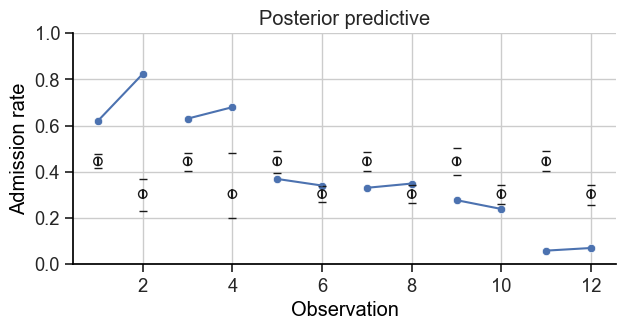

In [26]:
plot_posterior_preditive_checks_by_observation(admit, trace_11_7)

You can see the issue - the model predicts the same admission rate for men and women at each department.

Let's improve the model by adding department as a feature.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, delta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


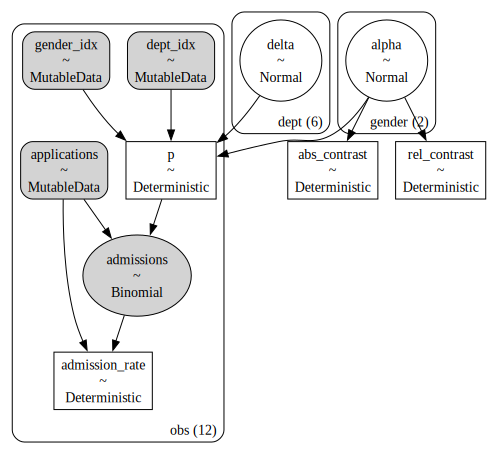

In [27]:
coords = {
    "obs": admit.index,
    "gender": genders,
    "dept": depts,
}
with pm.Model(coords=coords) as m11_8:
    # data
    gender_idx = pm.MutableData("gender_idx", admit.gender_idx, dims="obs")
    dept_idx = pm.MutableData("dept_idx", admit.dept_idx, dims="obs")
    applications = pm.MutableData("applications", admit.applications, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="gender")
    delta = pm.Normal("delta", mu=0, sigma=1.5, dims="dept")

    # model
    p = pm.Deterministic(
        "p", pm.math.invlogit(alpha[gender_idx] + delta[dept_idx]), dims="obs"
    )

    # likelihood
    admissions = pm.Binomial(
        "admissions", n=applications, p=p, observed=admit.admit, dims="obs"
    )
    admission_rate = pm.Deterministic(
        "admission_rate", admissions / applications, dims="obs"
    )

    # contrasts
    male_idx = genders.get_loc("male")
    female_idx = genders.get_loc("female")

    abs_contrast = pm.Deterministic("abs_contrast", alpha[male_idx] - alpha[female_idx])
    rel_contrast = pm.Deterministic(
        "rel_contrast",
        pm.math.invlogit(alpha[male_idx]) - pm.math.invlogit(alpha[female_idx]),
    )

    # inference button - increase draws for convergence
    trace_11_8 = pm.sample(draws=2000, tune=2000, random_seed=RANDOM_SEED)


m11_8.to_graphviz()

Look at the posterior

In [28]:
az.summary(
    trace_11_8,
    var_names=["alpha", "delta"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[male],-0.498,0.517,-1.390,0.278
alpha[female],-0.401,0.517,-1.295,0.377
delta[A],1.081,0.520,0.221,1.900
delta[B],1.035,0.521,0.137,1.826
delta[C],-0.181,0.520,-0.980,0.693
delta[D],-0.213,0.519,-1.023,0.647
delta[E],-0.657,0.523,-1.483,0.209
delta[F],-2.213,0.528,-3.056,-1.350


Look at the contrasts

In [29]:
az.summary(
    trace_11_8,
    var_names=["contrast"],
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
abs_contrast,-0.097,0.081,-0.228,0.029
rel_contrast,-0.022,0.019,-0.052,0.007


Now let's compare the posterior predictions

Sampling: [admissions]


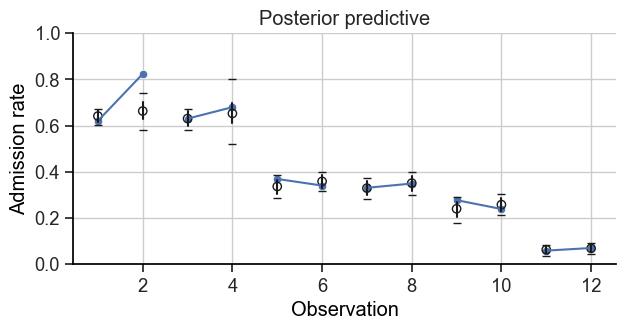

In [30]:
with m11_8:
    trace_11_8 = pm.sample_posterior_predictive(
        trace_11_8,
        var_names=["admissions", "admission_rate"],
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )


plot_posterior_preditive_checks_by_observation(admit, trace_11_8)

This looks much better although department A still doesn't fit very well.

Finally I want to look at the posterior correlations between the parameters.

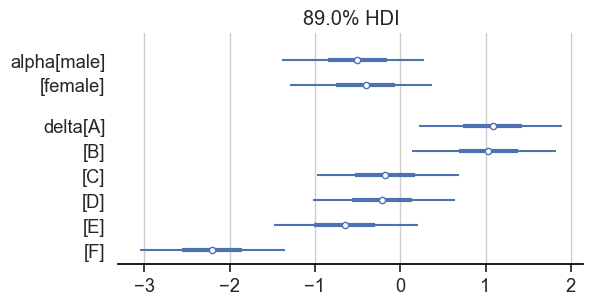

In [31]:
az.plot_forest(
    trace_11_8,
    var_names=["alpha", "delta"],
    combined=True,
    hdi_prob=0.89,
    figsize=(6, 3),
);

Note that the posterior distributions are very wide, but the actual posterior predictions have narrow HDIs.
This is due to posterior correlations.
Let's look at join distributions for pairs of parameters.
We just take the first two departments as an example - the others are similar.

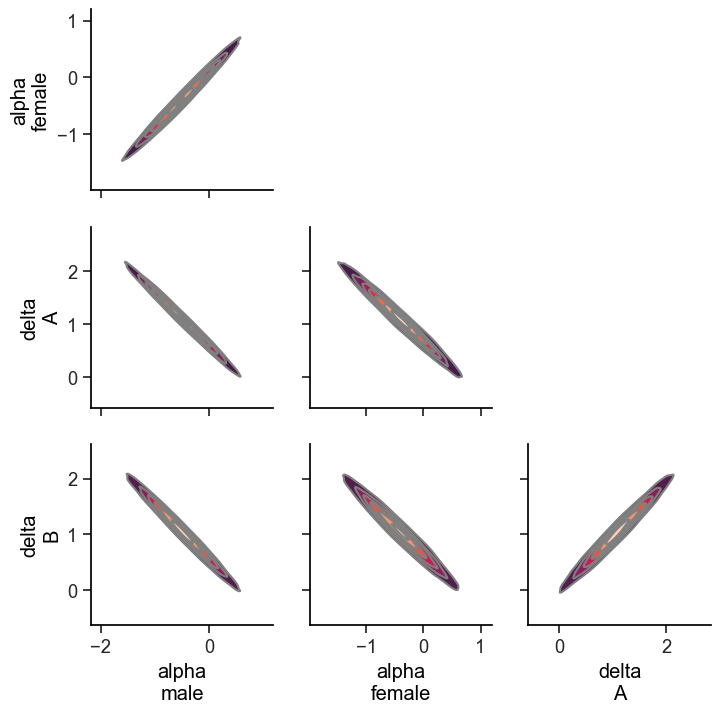

In [32]:
az.plot_pair(
    trace_11_8,
    var_names=["alpha", "delta"],
    coords={"dept": ["A", "B"]},
    kind="kde",
    figsize=(8, 8),
);

There are strong correlations between the posteriors due to redundency in the parameters.
This isn't a problem, but makes the marginal posterior distributions misleading.

## 11.2 Poisson Regression

### 11.2.1 Example: Oceanic tool complexity

In [33]:
# load data
kline = load_data(KLINE_FILE, delimiter=";")

kline["population"] = kline["population"].astype(float)

# transform features
kline["log_pop"] = np.log(kline.population)

kline_normaliser = StandardScaler().set_output(transform="pandas")
kline[["log_pop_norm"]] = kline_normaliser.fit_transform(kline[["log_pop"]])

# create index variable
kline["contact_id"] = (kline["contact"] == "high").astype(int)
contacts = ["low", "high"]

Let's ignore the bad prior examples and go straight for the complete model.

In [34]:
cultures = kline.culture.values
contacts = ["low", "high"]

coords = {
    "culture": cultures,
    "contact": contacts,
}
# note that setting mutable coords will allow us to change them for counterfactuals
with pm.Model(coords_mutable=coords) as m11_10:
    # data
    population = pm.MutableData("population", kline.population, dims="culture")
    log_pop_norm = pm.MutableData("log_pop_norm", kline.log_pop_norm, dims="culture")
    contact_id = pm.MutableData("contact_id", kline.contact_id, dims="culture")

    # priors
    alpha = pm.Normal("alpha", mu=3, sigma=0.5, dims="contact")
    beta = pm.Normal("beta", mu=0, sigma=0.2, dims="contact")

    # model
    mu = pm.Deterministic(
        "mu",
        pm.math.exp(alpha[contact_id] + beta[contact_id] * log_pop_norm),
        dims="culture",
    )

    # likelihood
    total_tools = pm.Poisson(
        "total_tools", mu=mu, observed=kline.total_tools, dims="culture"
    )

    # sample prior predictive
    trace_11_10 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta, total_tools]


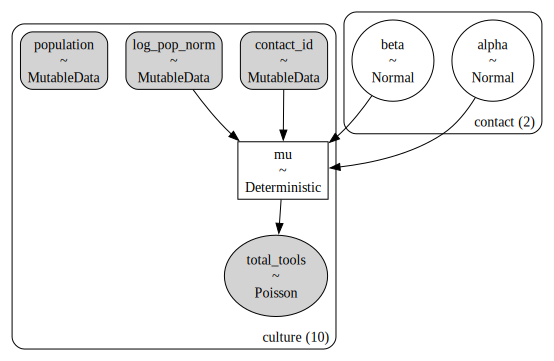

In [35]:
m11_10.to_graphviz()

Now plot a sample of prior regression lines

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


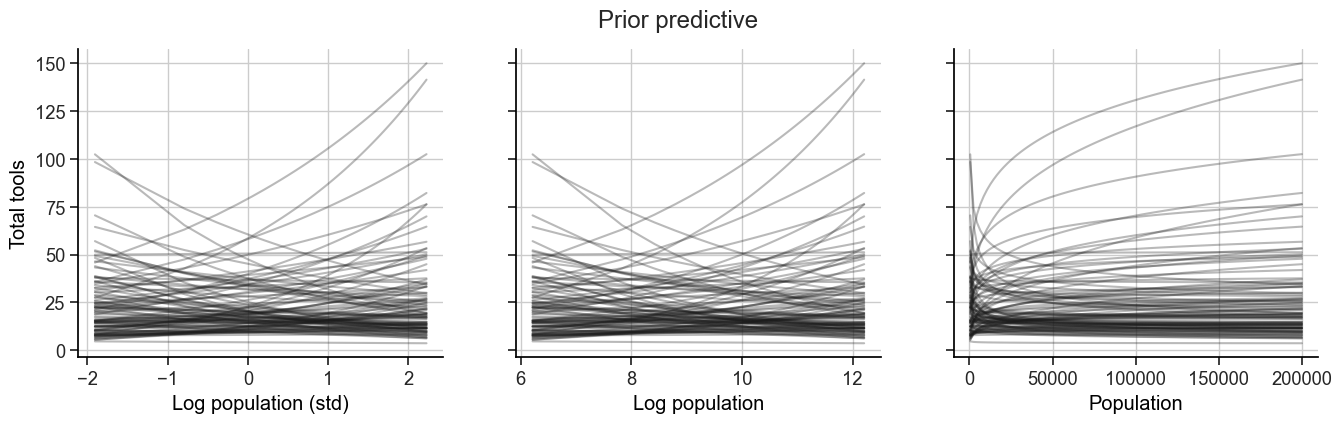

In [37]:
n_lines = 100
population_seq = np.linspace(500, 200000, 100)

log_pop_seq = np.log(population_seq)
log_pop_norm_seq = kline_normaliser.transform(log_pop_seq.reshape(-1, 1))["log_pop"]

# sample priors
prior_sample = trace_11_10.prior.isel(chain=0, contact=0, draw=slice(n_lines))
alpha_sample = prior_sample.alpha
beta_sample = prior_sample.beta

# coerce into compatible shapes
xv, alphav = np.meshgrid(log_pop_norm_seq, alpha_sample)
_, betav = np.meshgrid(log_pop_norm_seq, beta_sample)

# feed into model
lines = np.exp(alphav + betav * xv)

fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(16, 4))

x_dict = {
    "Log population (std)": log_pop_norm_seq,
    "Log population": log_pop_seq,
    "Population": population_seq,
}
for ax, (label, x_seq) in zip(axs, x_dict.items()):
    ax.plot(np.array([x_seq] * n_lines).T, lines.T, color="k", alpha=0.3)
    ax.set(xlabel=label)

axs[0].set(ylabel="Total tools")
fig.suptitle("Prior predictive");

Looks reasonable.

Now we sample and plot the model predictions against the true data.

In [38]:
with m11_10:
    trace_11_10 = pm.sample(draws=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


I think I need to generate counterfactuals in order to plot this.
Start with low contact

In [39]:
n_samples = 100

population_seq = np.linspace(500, 300000, n_samples)
log_pop_seq = np.log(population_seq)
log_pop_norm_seq = kline_normaliser.transform(log_pop_seq.reshape(-1, 1))[
    "log_pop"
].values

with m11_10:
    pm.set_data(
        {
            "population": population_seq,
            "log_pop_norm": log_pop_norm_seq,
            "contact_id": np.zeros(n_samples, dtype=int),
        },
        coords={"culture": np.arange(n_samples)},
    )
    low_contact_pp = pm.sample_posterior_predictive(
        trace_11_10,
        var_names=["mu", "total_tools"],
        predictions=True,
        random_seed=RANDOM_SEED,
    )

    pm.set_data(
        {
            "population": population_seq,
            "log_pop_norm": log_pop_norm_seq,
            "contact_id": np.ones(n_samples, dtype=int),
        },
        coords={"culture": np.arange(n_samples)},
    )
    high_contact_pp = pm.sample_posterior_predictive(
        trace_11_10,
        var_names=["mu", "total_tools"],
        predictions=True,
        random_seed=RANDOM_SEED,
    )

/Users/c.leonard/P/statistical-rethinking/env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Sampling: [total_tools]


Sampling: [total_tools]


Now plot the posteriors by different values of contact.

In [40]:
def plot_posterior_predictive_regression_line(
    predictor_data, posterior_data, color=None, hdi_prob=0.89, ax=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    ax.plot(
        predictor_data,
        posterior_data.mean(dim=["chain", "draw"]),
        color=color,
    )

    posterior_name = posterior_data.name
    hdi = az.hdi(posterior_data, hdi_prob=hdi_prob)[posterior_name]
    ax.fill_between(
        predictor_data,
        hdi.sel(hdi="lower"),
        hdi.sel(hdi="higher"),
        color=color,
        alpha=0.3,
    )

In [41]:
def plot_kline_posterior_regression_lines_by_contact(
    kline, low_contact_pp, high_contact_pp, x_col, ax=None
):
    if x_col not in ["log_pop_norm", "population"]:
        raise ValueError("x_col must be either 'log_pop_norm' or 'population'")

    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    hue_order = contacts
    sns.scatterplot(
        data=kline,
        x=x_col,
        y="total_tools",
        hue="contact",
        hue_order=hue_order,
        ax=ax,
    )

    plot_posterior_predictive_regression_line(
        low_contact_pp.predictions_constant_data[x_col],
        low_contact_pp.predictions.mu,
        color=colors[0],
        ax=ax,
    )

    plot_posterior_predictive_regression_line(
        high_contact_pp.predictions_constant_data[x_col],
        high_contact_pp.predictions.mu,
        color=colors[1],
        ax=ax,
    )

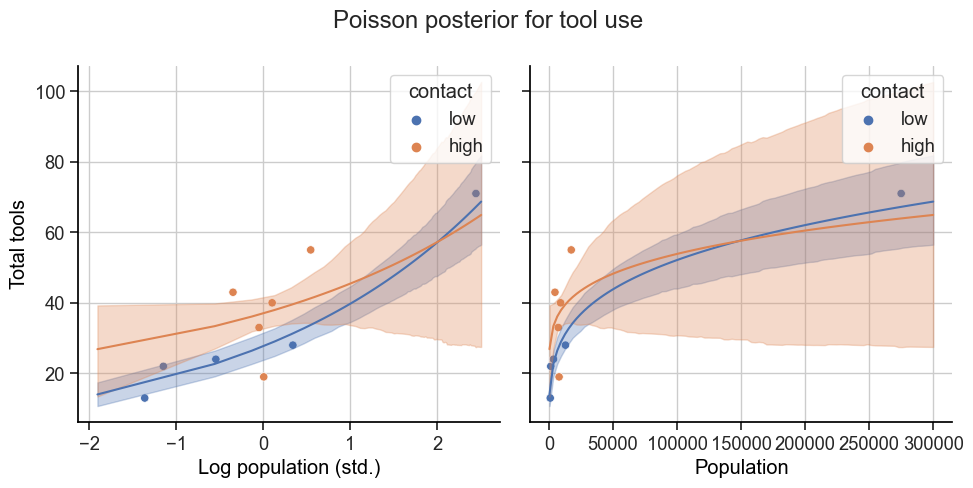

In [42]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

plot_kline_posterior_regression_lines_by_contact(
    kline, low_contact_pp, high_contact_pp, x_col="log_pop_norm", ax=axs[0]
)
plot_kline_posterior_regression_lines_by_contact(
    kline, low_contact_pp, high_contact_pp, x_col="population", ax=axs[1]
)

axs[0].set(
    xlabel="Log population (std.)",
    ylabel="Total tools",
)
axs[1].set(
    xlabel="Population",
)

fig.suptitle("Poisson posterior for tool use")
fig.tight_layout();

## 11.3 Multinomial and categorical models

### 11.3.1 Predictors matched to outcomes

Simulate data

In [43]:
N = 500

# set data about careers
career_data = pd.DataFrame()
career_data["income"] = np.array([1, 2, 5])
career_data["score"] = 0.5 * career_data["income"]
career_data["p"] = softmax(career_data["score"])

# simulate data about inviduals
individual_data = pd.DataFrame()
individual_data["career"] = np.random.choice(
    career_data.index, size=N, p=career_data["p"]
)

This is a Categorical model because the observed data isn't aggregated - it is a single category for each data point.

In this case the predictors are linked to categories (i.e. careers) rather than the individual data points.
We fit a linear model for each career.
We use a shared slope to model the effect of income but separate intercepts to account for other differences in frequency.

The individual linear models are actually for career *scores* which are mapped to probabilities using the softmax link function.
These scores only mean anything relatively; a higher score means a higher probability of that career.
We pivot the third career, but unlike in the text we include the slope parameter and income data.
This is because this contains important information that the model wouldn't otherwise be able to learn from.

\begin{align}
    C_i & \sim \text{Cat}\left(\mathbf{p} = (p^{(0)}, p^{(1)}, p^{(2)})\right) \\
    \mathbf{p} & = \text{softmax} \left( \mathbf{s} = (s^{(0)}, s^{(1)}, s^{(2)}) \right) \\
    s^{(0)} & = \alpha^{(0)} + \beta \cdot x^{(0)} \\
    s^{(1)} & = \alpha^{(1)} + \beta \cdot x^{(1)} \\
    s^{(2)} & =\beta \cdot x^{(2)} \\
    \alpha^{(*)} & \sim \text{Normal}\left(0, 1\right) \\
    \beta & \sim \text{Normal}\left(0, 0.5\right) \\
\end{align}

Now let's try building the model

In [44]:
coords = {
    "individual_id": individual_data.index,
    "career_id": career_data.index,
}
with pm.Model(coords_mutable=coords) as m11_13:
    # data
    income = pm.MutableData("income", career_data.income, dims="career_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=2)
    beta = pm.Normal("beta", mu=0, sigma=0.5)

    # model
    score = pm.Deterministic(
        "score",
        pm.math.stack(
            [
                alpha[0] + beta * income[0],
                alpha[1] + beta * income[1],
                beta
                * income[
                    2
                ],  # note the difference from the text - this has predictive info so should be pivoted
            ]
        ),
        dims="career_id",
    )
    p = pm.Deterministic("p", pm.math.softmax(score), dims="career_id")

    # likelihood
    career = pm.Categorical(
        "career", p=p, observed=individual_data.career, dims="individual_id"
    )

    # inference button
    trace_11_13 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [45]:
m11_13

 alpha ~ Normal(0, 1)
  beta ~ Normal(0, 0.5)
 score ~ Deterministic(f(beta, alpha))
     p ~ Deterministic(f(beta, alpha))
career ~ Categorical(p)

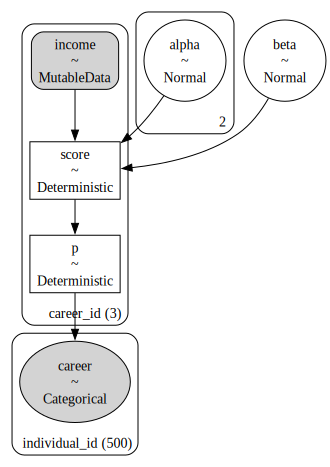

In [46]:
m11_13.to_graphviz()

Inspect the results

In [47]:
pm.summary(
    trace_11_13,
    var_names=["alpha", "beta"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],-0.284,0.728,-1.355,0.960
alpha[1],-0.128,0.551,-0.928,0.834
beta,0.430,0.183,0.172,0.759


Note that $\beta$ is positive so that higher career income is associated with higher probability of choosing that career.
Note also that the two $\alpha$ values are negative which implies that they are less likely than the third career (the pivot), without taking income into account.

I'll plot the posterior for $p$ to understand what this actually means in terms of probabilities.

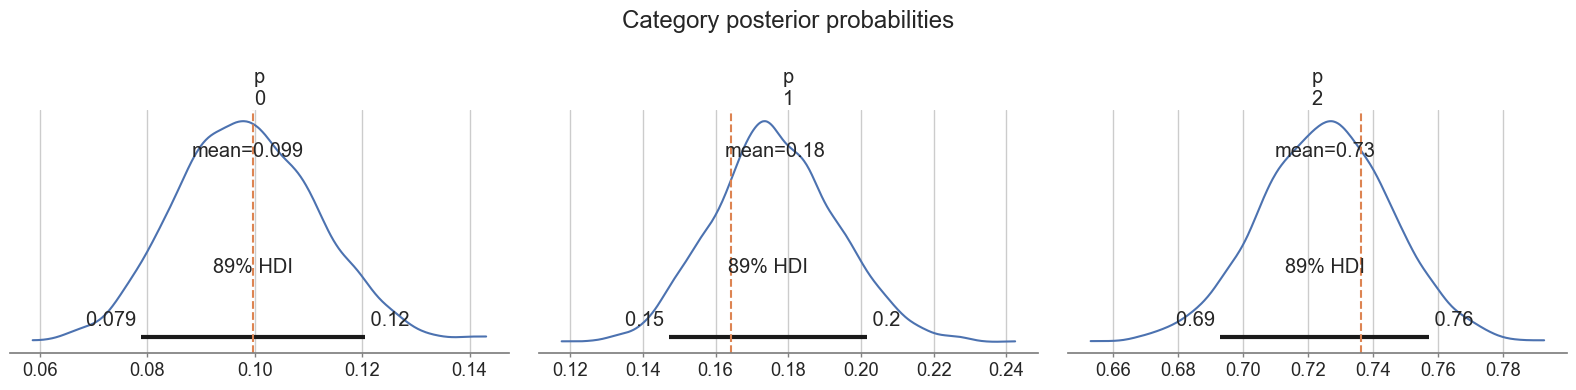

In [48]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))

az.plot_posterior(trace_11_13, var_names="p", hdi_prob=0.89, ax=axs)

# plot true values
for career_id in range(3):
    axs[career_id].axvline(career_data.loc[career_id, "p"], ls="--", color=colors[1])

fig.suptitle("Category posterior probabilities")
fig.tight_layout();

So we've actually done pretty well.

Let's construct counterfactual predictions for if the income of the second career doubled.

In [49]:
income_new = [1, 4, 5]

with m11_13:
    pm.set_data(
        {
            "income": income_new,
        }
    )
    pm.sample_posterior_predictive(
        trace_11_13,
        var_names=["score", "p"],
        extend_inferencedata=True,
        predictions=True,
        random_seed=RANDOM_SEED,
    )

Sampling: []


In [50]:
# get the difference
trace_11_13.predictions["p_diff"] = trace_11_13.predictions.p - trace_11_13.posterior.p

In [51]:
az.summary(
    trace_11_13,
    group="predictions",
    var_names=["p_diff"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
p_diff[0],-0.02,0.01,-0.04,-0.00
p_diff[1],0.16,0.08,0.04,0.30
p_diff[2],-0.14,0.07,-0.26,-0.04


We can see doubling the income of career two would increase the probability of an individual selecting that career by 15%.
But this is only relative to the other careers - it comes mostly at the expense of the third career.

### 11.3.2 Predictors matched to observations

Let's generate more simulated data

In [60]:
N = 500
individuals = pd.DataFrame(index=range(N))
career_ids = np.array([0, 1, 2])

# simulate income values between 0 and 1
individuals["family_income"] = stats.uniform.rvs(size=N, random_state=RANDOM_SEED)

# made up coefficients to estimate
b = np.array([-2, 0, 2])

scores = b * np.array([individuals.family_income.values] * 3).T + 0.5
probs = softmax(scores, axis=1)
individuals["career"] = np.concatenate(
    [np.random.choice(career_ids, size=1, p=probs[i, :]) for i in range(N)], axis=0
)

Now let's build the model

In [61]:
coords = {
    "individual_id": individuals.index,
    "career_id": career_ids,
}
with pm.Model(coords=coords) as m11_14:
    # data
    family_income = pm.MutableData(
        "family_income", individuals.family_income, dims="individual_id"
    )

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, shape=2)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=2)

    # linear models
    score = pm.Deterministic(
        "score",
        pm.math.stack(
            [
                alpha[0] + beta[0] * family_income,
                alpha[1] + beta[1] * family_income,
                np.zeros(individuals.shape[0]),
            ],
            axis=1,
        ),
        dims=("individual_id", "career_id"),
    )
    p = pm.Deterministic(
        "p", pm.math.softmax(score, axis=1), dims=("individual_id", "career_id")
    )

    # likelihood
    career = pm.Categorical(
        "career", p=p, observed=individuals.career, dims="individual_id"
    )

    # inference button
    trace_11_14 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


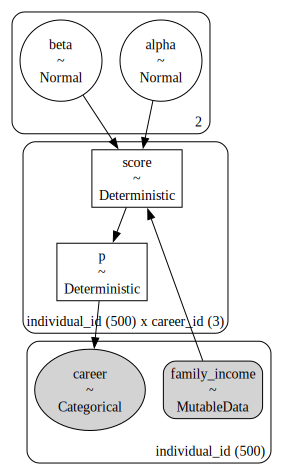

In [62]:
m11_14.to_graphviz()

In [63]:
az.summary(
    trace_11_14,
    var_names=["alpha", "beta"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],-0.545,0.224,-0.885,-0.176
alpha[1],-0.429,0.199,-0.739,-0.108
beta[0],-2.675,0.475,-3.416,-1.892
beta[1],-1.422,0.356,-1.972,-0.838


Again this is quite hard to interpret.
All we get is that as family income increases, the first and second careers become less likely, relative to the third career.

Let's plot the posteriors against the (in this case known) true scores and probabilities.

In [64]:
def plot_career_linear_model_posteriors(
    predictor_data,
    posterior_data,
    true_values,
    hdi_prob=0.89,
    ax=None,
):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    predictor_name = predictor_data.name
    posterior_name = posterior_data.name

    ordering = np.argsort(predictor_data)
    career_ids = posterior_data.coords["career_id"].values

    mean = posterior_data.mean(dim=["chain", "draw"])
    hdi = az.hdi(posterior_data, hdi_prob=0.89)[posterior_name]
    for career_id, color in zip(career_ids, colors):
        ax.plot(
            predictor_data.values[ordering],
            true_values[ordering, career_id],
            ls="--",
            color=color,
        )
        ax.plot(
            predictor_data.values[ordering],
            mean.sel(career_id=career_id).values[ordering],
            color=color,
            label=career_id,
        )
        ax.fill_between(
            predictor_data.values[ordering],
            hdi.sel(career_id=career_id, hdi="lower").values[ordering],
            hdi.sel(career_id=career_id, hdi="higher").values[ordering],
            color=color,
            alpha=0.3,
        )

    ax.set(
        xlabel=predictor_name,
        ylabel=posterior_name,
    )
    ax.legend(title="Career")

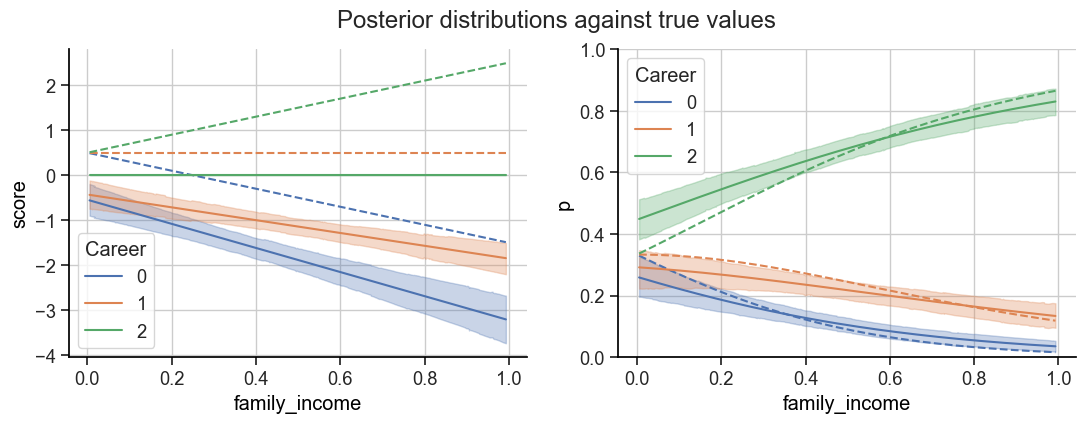

In [65]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 4))

plot_career_linear_model_posteriors(
    trace_11_14.constant_data.family_income,
    trace_11_14.posterior.score,
    scores,
    ax=axs[0],
)
plot_career_linear_model_posteriors(
    trace_11_14.constant_data.family_income, trace_11_14.posterior.p, probs, ax=axs[1]
)
axs[1].set(ylim=[0, 1])

fig.suptitle("Posterior distributions against true values");

Note that the scores are very different from the true values since these only matter relative to each other.

The posterior probabilities are actually pretty good.
In fact the main issue is that in the true data, the probabilities are equal when family income is zero.
That is, the intercept terms are equal, which is not an assumption that our model has.

Out of curiousity, let's see what happens if we remove the intercept term from the model.

In [66]:
coords = {
    "individual_id": individuals.index,
    "career_id": career_ids,
}
with pm.Model(coords=coords) as m11_14b:
    # data
    family_income = pm.MutableData(
        "family_income", individuals.family_income, dims="individual_id"
    )

    # priors
    beta = pm.Normal("beta", mu=0, sigma=1, shape=2)

    # linear models
    score = pm.Deterministic(
        "score",
        pm.math.stack(
            [
                beta[0] * family_income,
                beta[1] * family_income,
                np.zeros(individuals.shape[0]),
            ],
            axis=1,
        ),
        dims=("individual_id", "career_id"),
    )
    p = pm.Deterministic(
        "p", pm.math.softmax(score, axis=1), dims=("individual_id", "career_id")
    )

    # likelihood
    career = pm.Categorical(
        "career", p=p, observed=individuals.career, dims="individual_id"
    )

    # inference button
    trace_11_14b = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


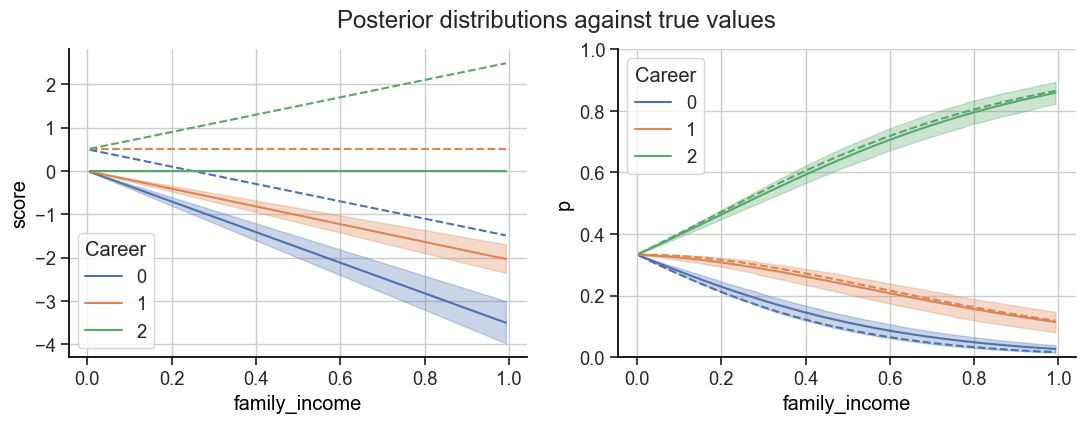

In [67]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 4))

plot_career_linear_model_posteriors(
    trace_11_14b.constant_data.family_income,
    trace_11_14b.posterior.score,
    scores,
    ax=axs[0],
)
plot_career_linear_model_posteriors(
    trace_11_14b.constant_data.family_income, trace_11_14b.posterior.p, probs, ax=axs[1]
)
axs[1].set(ylim=[0, 1])

fig.suptitle("Posterior distributions against true values");

Now this fits the data really well.